# TP: Building an MLP from Scratch for CIFAR-10 Classification

_From [Dataflowr Module 5](https://dataflowr.github.io/website/modules/5-stacking-layers/#practicals) by Marc Lelarge_

In this practical, you will implement a Multi-Layer Perceptron (MLP) from scratch using PyTorch to classify images from the CIFAR-10 dataset.

## System Setup

Import the required packages and check PyTorch version.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
Using device: cuda


## Part 1: Building the Dataset

### About CIFAR-10

CIFAR-10 is a dataset of 32x32 color images in 10 classes:
- **Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **Training images**: 50,000 (5,000 per class)
- **Test images**: 10,000 (1,000 per class)
- **Image size**: 32x32 pixels, RGB (3 channels)

### Data Preprocessing

For an MLP, we need to:
1. Convert images to tensors
2. Normalize pixel values (mean=0.5, std=0.5 for each channel)
3. Flatten 32x32x3 images into 1D vectors of size 3072

**TODO 1:** Create a transform pipeline using `transforms.Compose` that:
- Converts images to tensors with `transforms.ToTensor()`
- Normalizes with `transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))`

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

print("Transform pipeline created successfully!")

Transform pipeline created successfully!


### Loading CIFAR-10 Dataset

**TODO 2:** Load the CIFAR-10 dataset using `datasets.CIFAR10`.

Hints:
- Set `root='./data'` to specify download directory
- Set `train=True` for training set, `train=False` for test set
- Set `download=True` to download the dataset
- Use the transform pipeline you created above

Check the documentation: [datasets.CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

In [4]:
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print("Datasets loaded successfully!")

100%|██████████| 170M/170M [00:19<00:00, 8.88MB/s]


Datasets loaded successfully!


### Check Dataset Properties

**TODO 3:** Print the sizes of training and test datasets, and examine the class names.

In [5]:
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"\nClass names: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")

Training set size: 50000
Test set size: 10000

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10


### Creating DataLoaders

DataLoaders handle batching, shuffling, and parallel loading of data.

**TODO 4:** Create DataLoaders for training and testing.

Hints:
- Use `batch_size=128` for training
- Use `batch_size=100` for testing
- Set `shuffle=True` for training data
- Set `shuffle=False` for test data
- Set `num_workers=2` for parallel data loading

Check the documentation: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

Train loader: 391 batches
Test loader: 100 batches


### Visualize Sample Images

**TODO 5:** Visualize a batch of training images using matplotlib.

Hints:
- Get a batch using `next(iter(train_loader))`
- Use `torchvision.utils.make_grid()` to create a grid of images
- Don't forget to denormalize before displaying (reverse the normalization)

Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


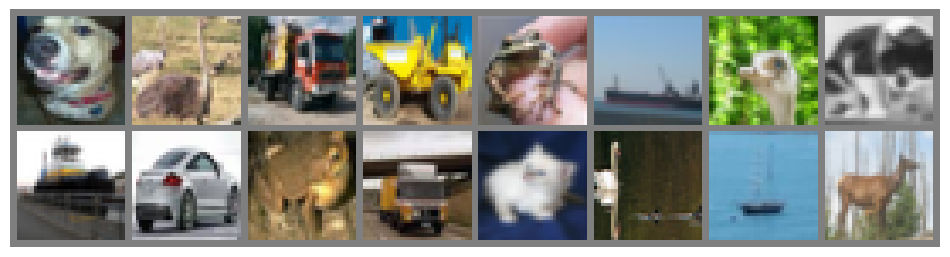


Labels: ['dog', 'bird', 'truck', 'truck', 'frog', 'ship', 'bird', 'cat', 'ship', 'automobile', 'frog', 'truck', 'cat', 'bird', 'ship', 'deer']


In [7]:
import torchvision

# Get a batch of training data
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Function to denormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Denormalize (reverse normalization)
    npimg = img.numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Make a grid from the first 16 images
grid = torchvision.utils.make_grid(images[:16], nrow=8)
imshow(grid)

# Print labels for the first 16 images
print(f"\nLabels: {[train_dataset.classes[label] for label in labels[:16]]}")

## Part 2: Understanding MLP Architecture

### What is an MLP?

A Multi-Layer Perceptron (MLP) is a fully connected neural network consisting of:
- **Input layer**: Takes flattened input (3072 values for 32x32x3 images)
- **Hidden layers**: One or more layers that learn features
- **Output layer**: Produces class probabilities (10 values for CIFAR-10)

### Architecture Design

We will build an MLP with the following structure:

```
Input: 32x32x3 image → Flatten → 3072 values
   ↓
Linear(3072 → 1000)  [Weights: 3072×1000 + 1000 bias = 3,073,000 parameters]
   ↓
ReLU activation
   ↓
Linear(1000 → 10)    [Weights: 1000×10 + 10 bias = 10,010 parameters]
   ↓
Output: 10 class scores
```

**Total parameters**: ~3.08 million

### Understanding Dimensions

Each linear layer performs: `output = input @ weights.T + bias`

For a batch of size B:
- Input shape: `[B, 3072]`
- After first linear: `[B, 1000]`
- After second linear: `[B, 10]`

### Non-Linear Activation Functions

**Why do we need activation functions?**

Without non-linearity, stacking multiple linear layers is equivalent to a single linear layer:
```
Layer1(Layer2(x)) = W1(W2*x + b2) + b1 = (W1*W2)*x + (W1*b2 + b1) = W3*x + b3
```

**ReLU (Rectified Linear Unit)**: `ReLU(x) = max(0, x)`
- Introduces non-linearity
- Computationally efficient
- Helps avoid vanishing gradient problem
- Most commonly used activation function

## Part 3: Building the MLP with PyTorch

### Using nn.Sequential

PyTorch provides `nn.Sequential` to stack layers sequentially. This is convenient for simple architectures.

**TODO 6:** Build the MLP model using `nn.Sequential` with:
1. `nn.Flatten()` - converts [B, 3, 32, 32] to [B, 3072]
2. `nn.Linear(3072, 1000)` - hidden layer
3. `nn.ReLU()` - activation function
4. `nn.Linear(1000, 10)` - output layer

Check the documentation:
- [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

### Verify Model Architecture

**TODO 7:** Print the model architecture and count the total number of parameters.

Hints:
- Print the model to see its structure
- Use `sum(p.numel() for p in model.parameters())` to count parameters

### Test Forward Pass

**TODO 8:** Test the model with a random batch to verify dimensions.

Hints:
- Create a random tensor of shape `[4, 3, 32, 32]` (batch of 4 images)
- Pass it through the model
- Verify output shape is `[4, 10]`

## Part 4: Training the MLP

### Loss Function and Optimizer

**Loss Function**: We use Cross-Entropy Loss for multi-class classification
- Combines `LogSoftmax` and `NLLLoss`
- Measures the difference between predicted probabilities and true labels

**Optimizer**: We use Stochastic Gradient Descent (SGD)
- Updates weights in the direction that reduces loss
- Momentum helps accelerate convergence

**TODO 9:** Create the loss function and optimizer.

Hints:
- Use `nn.CrossEntropyLoss()`
- Use `torch.optim.SGD` with:
  - `lr=0.01` (learning rate)
  - `momentum=0.9`
  - `model.parameters()` to optimize all parameters

Check the documentation:
- [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

### Training Loop

The training loop consists of:
1. **Forward pass**: Compute predictions
2. **Loss computation**: Calculate error
3. **Backward pass**: Compute gradients using `loss.backward()`
4. **Optimizer step**: Update weights using `optimizer.step()`
5. **Zero gradients**: Clear gradients with `optimizer.zero_grad()`

**TODO 10:** Implement the training function.

Hints:
- Set model to training mode: `model.train()`
- Loop over batches from the dataloader
- Move data to device (GPU/CPU)
- Perform forward pass, compute loss, backward pass, optimizer step
- Track running loss and accuracy
- Use `torch.max(outputs, 1)` to get predicted classes

### Train the Model

**TODO 11:** Train the model for 10 epochs.

Note: Training may take several minutes depending on your hardware.

## Part 5: Model Evaluation

### Test Function

**TODO 12:** Implement a function to evaluate the model on the test set.

Hints:
- Set model to evaluation mode: `model.eval()`
- Use `torch.no_grad()` to disable gradient computation
- Calculate test loss and accuracy
- Store predictions and probabilities for analysis

### Evaluate on Test Set

**TODO 13:** Run the test function and report accuracy.

## Next?

What happens if you
- switch the training to a GPU? Is it faster?
- Remove the `ReLU()`?
- Increase the learning rate?
- Stack more layers?
- Perform more epochs?